おまじない

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

In [4]:
test.head()

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,30,Private,107793,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,56,United-States
1,1,39,Private,76767,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,60,United-States
2,2,28,Self-emp-not-inc,149324,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,7,United-States
3,3,50,State-gov,276241,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
4,4,53,Private,177647,Bachelors,13,Divorced,Exec-managerial,Unmarried,White,Male,0,0,40,United-States


データを見る・データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [5]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [6]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [7]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [8]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [9]:
testX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education-num   16281 non-null  int64 
 4   marital-status  16281 non-null  object
 5   occupation      16281 non-null  object
 6   relationship    16281 non-null  object
 7   race            16281 non-null  object
 8   sex             16281 non-null  object
 9   capital-gain    16281 non-null  int64 
 10  capital-loss    16281 non-null  int64 
 11  hours-per-week  16281 non-null  int64 
 12  native-country  16281 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.6+ MB


In [10]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education-num   16280 non-null  int64 
 4   marital-status  16280 non-null  object
 5   occupation      16280 non-null  object
 6   relationship    16280 non-null  object
 7   race            16280 non-null  object
 8   sex             16280 non-null  object
 9   capital-gain    16280 non-null  int64 
 10  capital-loss    16280 non-null  int64 
 11  hours-per-week  16280 non-null  int64 
 12  native-country  16280 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.6+ MB


In [11]:
trainX.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.603808,1.899753e+05,10.089558,1131.057617,88.075369,40.410012
std,13.672102,1.048903e+05,2.570911,7672.406043,405.251482,12.311716
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.186912e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.789955e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376340e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.226583e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
testX.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.559487,1.895814e+05,10.071801,1024.243351,86.532338,40.464898
std,13.609075,1.062084e+05,2.574576,7086.407756,400.666956,12.383353
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173630e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.776330e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.366870e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


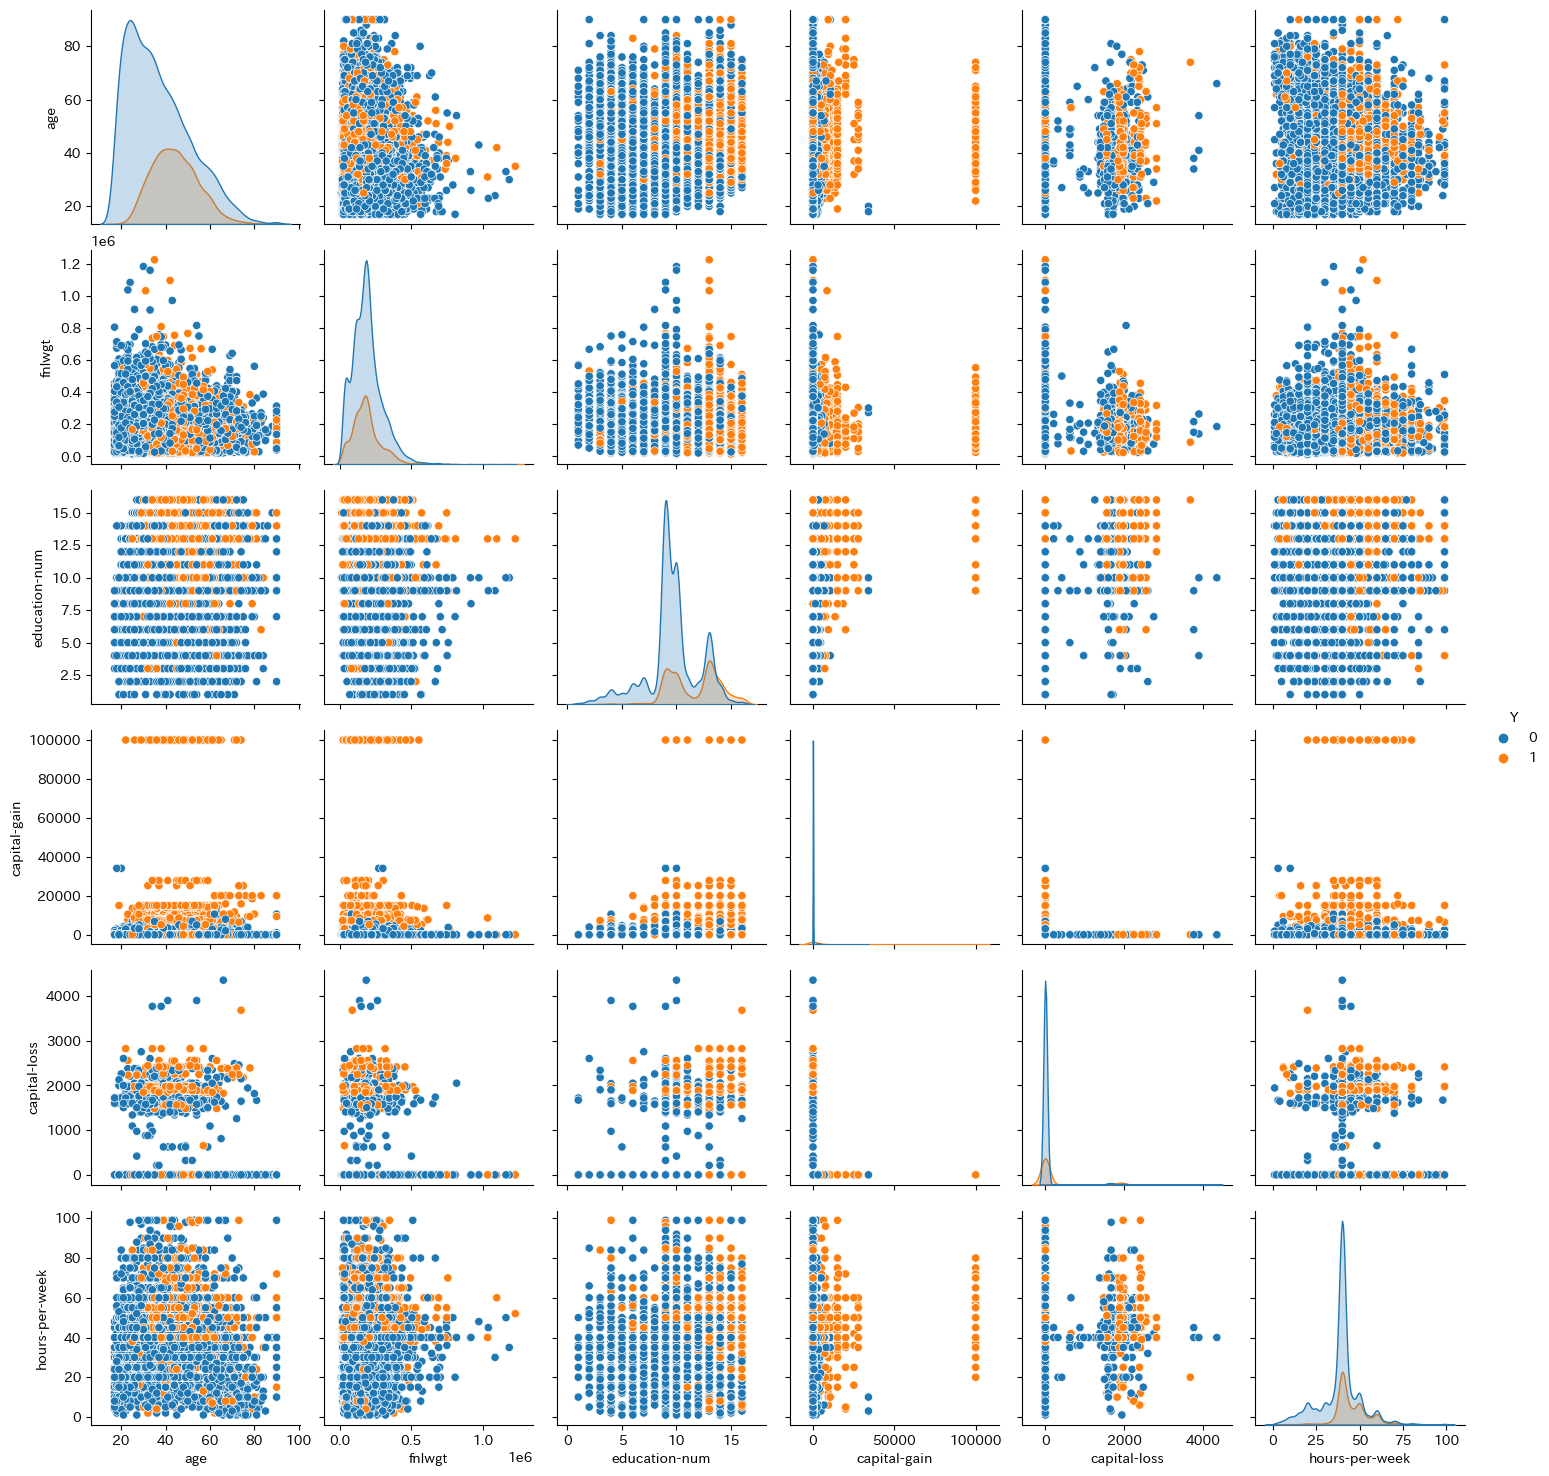

In [13]:
sns.pairplot(train, hue="Y")

In [14]:
workclass = pd.crosstab(trainX["workclass"],y,margins=True)
workclass["ratio"] = workclass[1]/workclass["All"]
workclass["odds"] = workclass[1]/workclass[0]
workclass.sort_values(by="ratio")

Y,0,1,All,ratio,odds
workclass,,,,,
Never-worked,4,0,4,0.000000,0.000000
Without-pay,6,0,6,0.000000,0.000000
?,858,92,950,0.096842,0.107226
Private,8756,2525,11281,0.223828,0.288374
All,12288,3992,16280,0.245209,0.324870
Self-emp-not-inc,923,358,1281,0.279469,0.387866
State-gov,470,183,653,0.280245,0.389362
Local-gov,714,319,1033,0.308809,0.446779
Federal-gov,318,194,512,0.378906,0.610063


In [15]:
maritalstatus = pd.crosstab(trainX["marital-status"],y,margins=True)
maritalstatus["ratio"] = maritalstatus[1]/maritalstatus["All"]
maritalstatus["odds"] = maritalstatus[1]/maritalstatus[0]
maritalstatus.sort_values(by="ratio")

Y,0,1,All,ratio,odds
marital-status,,,,,
Never-married,5083,263,5346,0.049196,0.051741
Separated,468,34,502,0.067729,0.072650
Married-spouse-absent,210,16,226,0.070796,0.076190
Widowed,460,37,497,0.074447,0.080435
Divorced,1993,247,2240,0.110268,0.123934
All,12288,3992,16280,0.245209,0.324870
Married-AF-spouse,9,7,16,0.437500,0.777778
Married-civ-spouse,4065,3388,7453,0.454582,0.833456


In [16]:
occupation = pd.crosstab(trainX["occupation"],y,margins=True)
occupation["ratio"] = occupation[1]/occupation["All"]
occupation["odds"] = occupation[1]/occupation[0]
occupation.sort_values(by="ratio")

Y,0,1,All,ratio,odds
occupation,,,,,
Priv-house-serv,75,0,75,0.000000,0.000000
Other-service,1568,66,1634,0.040392,0.042092
Handlers-cleaners,636,37,673,0.054978,0.058176
?,862,92,954,0.096436,0.106729
Machine-op-inspct,848,117,965,0.121244,0.137972
Farming-fishing,440,64,504,0.126984,0.145455
Adm-clerical,1667,287,1954,0.146878,0.172166
Transport-moving,593,166,759,0.218709,0.279933
Craft-repair,1563,488,2051,0.237933,0.312220


In [17]:
relationship = pd.crosstab(trainX["relationship"],y,margins=True)
relationship["ratio"] = relationship[1]/relationship["All"]
relationship["odds"] = relationship[1]/relationship[0]
relationship.sort_values(by="ratio")

Y,0,1,All,ratio,odds
relationship,,,,,
Own-child,2522,39,2561,0.015228,0.015464
Other-relative,465,15,480,0.031250,0.032258
Unmarried,1587,111,1698,0.065371,0.069943
Not-in-family,3729,452,4181,0.108108,0.121212
All,12288,3992,16280,0.245209,0.324870
Husband,3565,2984,6549,0.455642,0.837027
Wife,420,391,811,0.482121,0.930952


In [18]:
race = pd.crosstab(trainX["race"],y,margins=True)
race["ratio"] = race[1]/race["All"]
race["odds"] = race[1]/race[0]
race.sort_values(by="ratio")

Y,0,1,All,ratio,odds
race,,,,,
Other,135,10,145,0.068966,0.074074
Black,1385,199,1584,0.125631,0.143682
Amer-Indian-Eskimo,123,18,141,0.127660,0.146341
All,12288,3992,16280,0.245209,0.324870
White,10270,3611,13881,0.260140,0.351607
Asian-Pac-Islander,375,154,529,0.291115,0.410667


In [19]:
sex = pd.crosstab(trainX["sex"],y,margins=True)
sex["ratio"] = sex[1]/sex["All"]
sex["odds"] = sex[1]/sex[0]
sex.sort_values(by="ratio")

Y,0,1,All,ratio,odds
sex,,,,,
Female,4827,617,5444,0.113336,0.127823
All,12288,3992,16280,0.245209,0.324870
Male,7461,3375,10836,0.311462,0.452352


In [20]:
nativeCountry = pd.crosstab(trainX["native-country"],y,margins=True)
nativeCountry["ratio"] = nativeCountry[1]/nativeCountry["All"]
nativeCountry["odds"] = nativeCountry[1]/nativeCountry[0]
nativeCountry.sort_values(by="ratio")

Y,0,1,All,ratio,odds
native-country,,,,,
Nicaragua,23,0,23,0.000000,0.000000
Outlying-US(Guam-USVI-etc),8,0,8,0.000000,0.000000
Honduras,5,0,5,0.000000,0.000000
Columbia,34,1,35,0.028571,0.029412
Guatemala,24,1,25,0.040000,0.041667
Mexico,317,15,332,0.045181,0.047319
Peru,17,1,18,0.055556,0.058824
Dominican-Republic,32,2,34,0.058824,0.062500
Portugal,15,1,16,0.062500,0.066667


Memo  
workclass・occupation・native-countryの?、キャピタルゲイン・ロスの0じゃない値、歳・hours-per-weekの外れ値？をどう扱うか  
男女比の偏り  
trainX["education"]のダミー変数としてtrainX["education-num"]を使える